# Lab 04 - Logistic Regression

In this lab, we will train a logistic regression and validate its outcome using scikit-learn, and calculate some validation measures over our model. In future labs, we will dig deeper into variable selection, regularization, and other measures to improve the quality of the model. This lab only focuses on

In [ ]:
# Package import
import pandas as pd
import numpy as np

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [ ]:
# Get the data
!gdown https://drive.google.com/uc?id=12o15jDuv1RMc8us7ymzj4W_4QeNVB1ii

Downloading...
From: https://drive.google.com/uc?id=12o15jDuv1RMc8us7ymzj4W_4QeNVB1ii
To: /content/email.txt
100% 277k/277k [00:00<00:00, 119MB/s]


In [ ]:
# Load the data using pandas. We remove the time column since it is not useful for our analysis.
emails = pd.read_table("email.txt").drop('time',axis='columns')

# Display the first few rows of the data
emails.head()

,spam,to_multiple,from,cc,sent_email,image,attach,dollar,winner,inherit,viagra,password,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess,number
0,0,0,1,0,0,0,0,0,no,0,0,0,11.370,202,1,0,0,0,0,big
1,0,0,1,0,0,0,0,0,no,0,0,0,10.504,202,1,0,0,0,1,small
2,0,0,1,0,0,0,0,4,no,1,0,0,7.773,192,1,0,0,0,6,small
3,0,0,1,0,0,0,0,0,no,0,0,0,13.256,255,1,0,0,0,48,small
4,0,0,1,0,0,0,0,0,no,0,0,2,1.231,29,0,0,0,0,1,none


In [ ]:
# Display the data types of the columns
emails.dtypes

,0
spam,int64
to_multiple,int64
from,int64
cc,int64
sent_email,int64
image,int64
attach,int64
dollar,int64
winner,object
inherit,int64


In [ ]:
# Display the summary statistics of the data
emails.describe()

,spam,to_multiple,from,cc,sent_email,image,attach,dollar,inherit,viagra,password,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess
count,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000
mean,0.093599,0.158123,0.999235,0.404489,0.277990,0.048457,0.132874,1.467228,0.038001,0.002040,0.108136,10.706586,230.658505,0.695231,0.261413,0.080337,0.001785,6.584290
std,0.291307,0.364903,0.027654,2.666424,0.448066,0.450848,0.718518,5.022298,0.267899,0.127759,0.959931,14.645786,319.304959,0.460368,0.439460,0.271848,0.042220,51.479871
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.459000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.856000,119.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.084000,298.000000,1.000000,1.000000,0.000000,0.000000,4.000000
max,1.000000,1.000000,1.000000,68.000000,1.000000,20.000000,21.000000,64.000000,9.000000,8.000000,28.000000,190.087000,4022.000000,1.000000,1.000000,1.000000,1.000000,1236.000000


There are no null values in our data. We only need to worry about standardization and transforming categorical variables. For categorical variables, you **must** ensure that:

1. Every category has a significant number of cases.
2. Every category is representative of the target categories.

In small or biased datasets, it may happen that a category has 100% of one class, or 0% of another (in non-binary situations). It may also happen that a category is mispecified. Thus, you must first study categorical variables and, if any of these case happen, **combine these categories in either an "other" category or combine them with a similar one in meaning**. Otherwise, your model will be biased.

Let's study our categorical variables.

In [ ]:
# Create crosstab of the winner and the spam columns.
# This variable is useless as there is too few cases in "yes" (only 1.6% of the data)
pd.crosstab(emails['winner'], emails['spam'], margins=True)

spam,0,1,All
winner,,,
no,3510,347,3857
yes,44,20,64
All,3554,367,3921


In [ ]:
# Create crosstab of the number and spam columns
# In reality, it is better to have at least 5% of data is in each cell (in a column)
pd.crosstab(emails['number'], emails['spam'], margins=True)

spam,0,1,All
number,,,
big,495,50,545
none,400,149,549
small,2659,168,2827
All,3554,367,3921


We see that, for the winner variable, the "yes" category is small, with around 1.6% of the data. It may be it is not significant enough to provide a signal. As our dataset is very small, I will leave the variable, but in a real-life setting it may be overfit to the sample, so it may be wise to remove it. The decision to do so is 100% based on judgement, as it is not signficant in statistical sense, you cannot use statistics to determine its usefulness.

Let's keep it then and turn it into a dummy variable.

In [ ]:
# Create a dummy variable for the winner and the spam column
emails = pd.get_dummies(emails, drop_first=True)
emails

,spam,to_multiple,from,cc,sent_email,image,attach,dollar,inherit,viagra,...,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess,winner_yes,number_none,number_small
0,0,0,1,0,0,0,0,0,0,0,...,11.370,202,1,0,0,0,0,False,False,False
1,0,0,1,0,0,0,0,0,0,0,...,10.504,202,1,0,0,0,1,False,False,True
2,0,0,1,0,0,0,0,4,1,0,...,7.773,192,1,0,0,0,6,False,False,True
3,0,0,1,0,0,0,0,0,0,0,...,13.256,255,1,0,0,0,48,False,False,True
4,0,0,1,0,0,0,0,0,0,0,...,1.231,29,0,0,0,0,1,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3916,1,0,1,0,0,0,0,0,0,0,...,0.332,12,0,0,0,0,0,False,False,True
3917,1,0,1,0,0,0,0,1,0,0,...,0.323,15,0,0,0,0,0,False,False,True
3918,0,1,1,0,0,0,0,0,0,0,...,8.656,208,1,0,0,0,5,False,False,True
3919,0,1,1,0,0,0,0,0,0,0,...,10.185,132,0,0,0,0,0,False,False,True


Let's study our class variable.

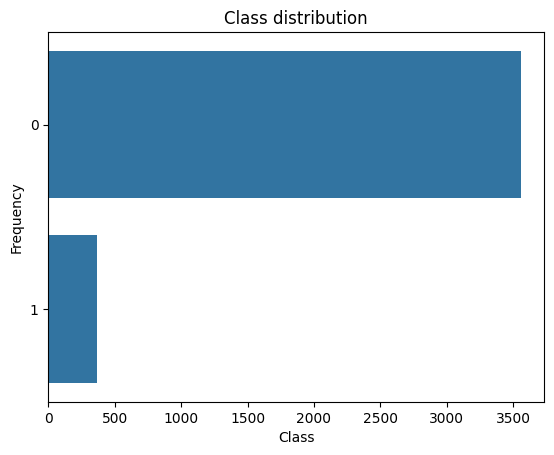

In [ ]:
# Check out class distribution. We transform the class column to a categorical variable to plot it.
sns.countplot(emails['spam'].astype('category'))
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# How many positive class?
posrate = emails.spam.mean()
print(f"The positive rate of the sample is {posrate*100:.2f}%")

The positive rate of the sample is 9.36%


We can see the problem is highly imbalanced. We will have to deal with that to get a more effective model. What is the baseline accuracy of our problem?

In [ ]:
# Baseline accuracy?
# Baseline accuracy is the minimum accuracy that we should achieve
# 90.64% accuracy can be easily achieved by randomly creating a prediction with 90% of Neg, 10% of Pos
baselineacc = 1 - posrate
print(f"The baseline accuracy of the problem is {baselineacc*100:.2f}%")

The baseline accuracy of the problem is 90.64%


Any model below this accuracy will be worse than just using the observed positive / total rate.

## Generating a test / train split

Let's create a model. A pure logistic regression (without parameter tuning) does not require a validation sample, as there are no iterative decisions that need to be made. Later in the course, we will run logistic regressions that require parameter tuning and variable selection, at which stage we will require one.

For this lab, let's just use a train/test split.

In [ ]:
# Split data, train logistic regression. 30% of the data will be reserved as test data.
Xtrain, Xtest, ytrain, ytest = train_test_split(emails.drop('spam',axis='columns'),
                          emails['spam'],
                          test_size=0.3,
                          random_state=0,
                          stratify=emails['spam'])

Let's go into detail with the function.

1. The first two parameters are the X and Y vector to split.
2. The `test_size` parameter is the percentage of the cases that are to be allocated to the test set.
3. The `random_state` is the initialization of the randomness. Computers cannot create true randomness, so they approximate it using intelligent functions that require a [random seed](https://en.wikipedia.org/wiki/Random_seed). Remember to set one! Otherwise, a new run of the model may lead to different values. **Use your student ID for the homework**.
4. The `stratify` parameter indicates whether to stratify the sampling or not. If you just do random sampling, there is a big chance that, if the sample is imbalanced, to alter significantly the balance of classes. With stratify set to the target, we can sample without that problem.

Now we are ready to create our model. We should:

1. Normalize the data following a standard normalization for those variables that require it.
2. Train a logistic regression with a [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html) object.

And we need to do this on the train set, and apply it to this (and any other) test set. You could create two different models, one for normalizing and one for the model, and apply them separately. However, scikit-learn has the powerful [Pipeline](https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html) class, that allows us to apply functions in sequence to the data, or even to split the data into pieces and apply functions to parts of it. We will see an example that normalizes the data and then defines the logistic regression. As the course progresses these will get much more complex, take some time to study it!

Only the non-binary variables require standardization. There is a big discussion on the community on [whether standardizing binary variables makes sense](https://stats.stackexchange.com/questions/59392/should-you-ever-standardise-binary-variables). My answer would be, no, it does not. And the fact that the outcome will be in the same range as the z-scaled ones means I would not risk it. We can apply a transform to a partial set of data using a [ColumnTransformer](https://scikit-learn.org/1.5/modules/compose.html#column-transformer) function.

In [ ]:
# Define the features to transform
features_to_transform = ['cc', 'image', 'attach', 'dollar', 'viagra',
              'password', 'num_char', 'line_breaks', 'exclaim_mess']

# Create a ColumnTransformer object that scales the features to transform
transform_numbers = ColumnTransformer([('scaler', StandardScaler(), features_to_transform)],
                     remainder='passthrough',
                     verbose_feature_names_out=False)

# Create a pipeline that scales the features and trains a logistic regression model
logit_pipe = Pipeline([
    ('scaler', transform_numbers),
    ('logistic_regression', LogisticRegression(solver='lbfgs',
                          penalty = None,
                          max_iter=10000,
                          verbose=1,
                          random_state=20252201,
                          n_jobs=-1,
                          class_weight='balanced'))
])

The input for the ColumnTransformer are a lists of operators, each consistent of a thruple `(name, function, variables_to_apply_it_to)`. One quirk of this function is that you **must** provide it as a list (between square brackets), even if you only have one operator, as we do. Another important parameter is the `remainder='passthrough'` parameter. It means that those variables that did not have a treatment must be returned, just without any changes. The default is `remainder='drop'`! If you forget to add it, you will lose variables.

Then we define the Pipeline, that receives any list with all the operators that you want to train, in sequence. In our cases, it is our column transformer, and then the logistic regression. Some important definitions in the LogisticRegression operator:

1. The `class_weight="balanced"` parameter tells the logistic regression to correct the imbalance by setting an error cost so that making a mistake in the positive class is equivalent to making a mistake in the negative class. It is always better to train this way and then move the cutoff to the desired range, otherwise the model will be severely imbalanced.
2. The `njobs=-1` tells sklearn to use all available cores for training. This can significantly speed up processing in large datasets, but it uses (linearly) more RAM memory. If you can get away with it, always give it a high number of cores!
3. The `maxiter=10000` tells sklearn to continue iterating for 10000 rounds at most. We see in the output that the training stops at iteration 50. Always give enough iterations to converge. Large problems may need hundreds of thousands of iterations or more! Check the convergence status by comparing your `maxiter` with the `n_iter_` property of the LogisticRegression output (which you can access here by `lr.named_steps['logistic_regression'].n_iter_`).

Now we are ready to fit the model. At this point, the model is run!

In [ ]:
# Train the model
logit_pipe.fit(Xtrain, ytrain)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['cc', 'image', 'attach',
                                                   'dollar', 'viagra',
                                                   'password', 'num_char',
                                                   'line_breaks',
                                                   'exclaim_mess'])],
                                   verbose_feature_names_out=False)),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    n_jobs=-1, penalty=None,
                                    random_state=20252201, verbose=1))])

In [ ]:
# Get the training parameters in a dataframe with the corresponding feature names
training_params = pd.DataFrame(logit_pipe.named_steps['logistic_regression'].coef_,
                               columns=Xtrain.columns)

# Get the intercept of the logistic regression model (betas)
training_params['intercept'] = logit_pipe.named_steps['logistic_regression'].intercept_
training_params

,to_multiple,from,cc,sent_email,image,attach,dollar,inherit,viagra,password,...,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess,winner_yes,number_none,number_small,intercept
0,0.006499,-1.347421,0.676533,-0.390746,1.135503,-0.549439,0.239424,-1.300725,0.608871,-3.077456,...,-14.808288,0.196751,-0.412961,-1.759959,0.06224,2.557189,1.776728,0.239626,-1.075511,7.324249




Let's predict over the test set and get some performance analyses!

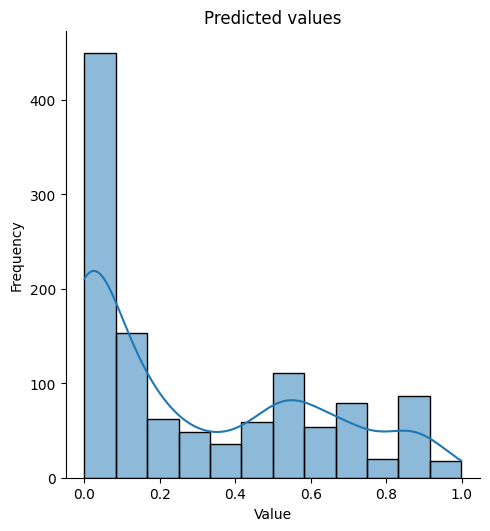

In [ ]:
# Predict on test
ytest_pred = logit_pipe.predict_proba(Xtest)

# Plot the distribution of the predicted values
sns.displot(ytest_pred[:,1], kde=True)
plt.title('Predicted values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

`predict_proba` returns the probabilities. You can return the predictions using a 0.5 cutoff with `predict`. You can use a list comprehension to move the cutoff to any value that you want. As we trained with a weighted error, 0.5 is the maximum likelihood cutoff, so we can use that one (assuming costs of errors in class 0 and class 1 are equal).

In [ ]:
print(classification_report(ytest, logit_pipe.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.99      0.75      0.85      1067
           1       0.27      0.89      0.41       110

    accuracy                           0.76      1177
   macro avg       0.63      0.82      0.63      1177
weighted avg       0.92      0.76      0.81      1177



We get a 75% accuracy, not bad! Let's plot the confusion matrix.

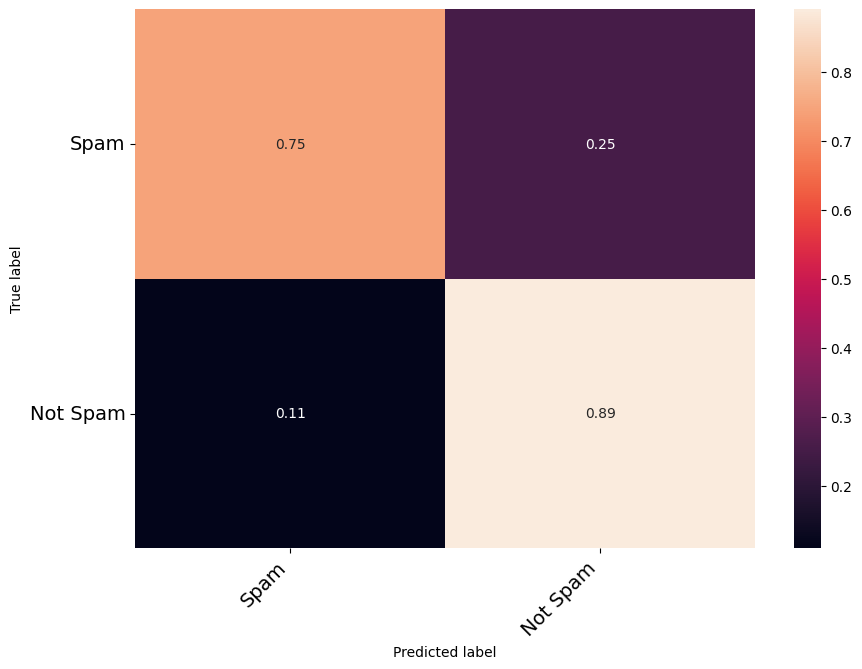

In [ ]:
# Calculate confusion matrix
confusion_matrix_lr = confusion_matrix(ytest, logit_pipe.predict(Xtest))

# Turn matrix to percentages
confusion_matrix_lr = confusion_matrix_lr.astype('float') / confusion_matrix_lr.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_lr,
        index=['Spam', 'Not Spam'], columns=['Spam', 'Not Spam'],
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

As expected, the output is relatively balanced and the performance follow the classification report. Let's plot the AUC curve to see the performance over all cutoffs.

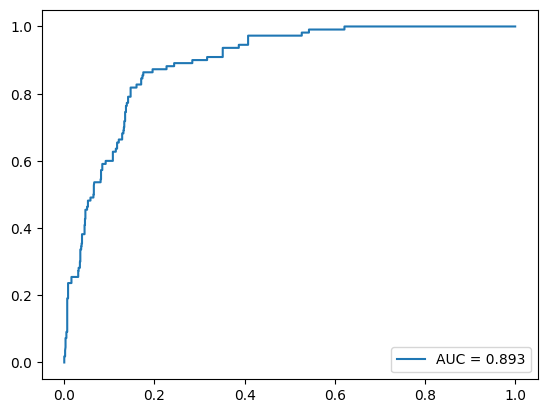

In [27]:
# Calculate the ROC curve points
# Prob of getting 1
fpr, tpr, thresholds = roc_curve(y_true=ytest, y_score=ytest_pred[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true=ytest, y_score=ytest_pred[:,1]), decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label=f"AUC = {auc:.3f}")
plt.legend(loc=4)
plt.show()

The model looks pretty good! We get an excellent AUC. However, AUCs are positively biased (they give a very high number) the higher the imbalance. If you know what areas you need to use, that is, what acceptable error ranges you have to use, you can use a [partial AUC](https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve) by providing a maximum false positive rate to the `roc_auc_score` function with the [`max_fpr`](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.roc_auc_score.html) parameter.